In [1]:
# this notebook builds off the log-log model established in the notebook 'Darden_Diamond_Price_Testing'
# here the lin reg model will add an interaction variable to account for D-type diamonds being more expensive
# at the end, a very roughly put together Deep Neural Network using keras will be tested as well

In [2]:
# import libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import data sets
# training data
diamond_data_train = pd.read_csv('diamond_train.csv')

# holdout test data
diamond_data_holdout = pd.read_csv('diamond_test.csv')

# training data, under 'Clarity' columns, has value FL, while holdout testing data does not
# remove the 4 sample rows of data that have value FL under 'Clarity' column
# new dimensions should have only 5996 rows
mask = diamond_data_train['Clarity'] == 'FL'
diamond_data_train_mask = diamond_data_train.loc[~mask]

# confirm new dimensions, with the 4 rows removed
diamond_data_train_mask.shape

(5996, 9)

In [4]:
# create the 'X' and 'y' variables for model training
# 'X' will drop 'ID' and 'Price columns'
X = diamond_data_train_mask.drop(['ID', 'Price'], axis=1)

# check data set
X.head(), X.shape

(   Carat Weight    Cut Color Clarity Polish Symmetry Report
 0          1.10  Ideal     H     SI1     VG       EX    GIA
 1          0.83  Ideal     H     VS1     ID       ID   AGSL
 2          0.85  Ideal     H     SI1     EX       EX    GIA
 3          0.91  Ideal     E     SI1     VG       VG    GIA
 4          0.83  Ideal     G     SI1     EX       EX    GIA, (5996, 7))

In [5]:
# continue to manipulate X for training purposes
# first make a copy of X named X_logCW
X_logCW = X.copy()

# get dummy variables to account for qualitative variables
X_logCW_dummies = pd.get_dummies(X_logCW)

# create new column for natural log CW
X_logCW_dummies['logCW'] = np.log(X_logCW_dummies.loc[:, 'Carat Weight'])

# create interaction variable column where: CW x Color_D
X_logCW_dummies['logCW*D'] = X_logCW_dummies['logCW'] * X_logCW_dummies['Color_D']

# drop 'Carat Weight' column and rename to X_manip for simplicity
X_manip = X_logCW_dummies.drop('Carat Weight', axis=1)

In [6]:
# check data set
X_manip.head()

,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,Color_H,...,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA,logCW,logCW*D
0,0,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0.095310,0.0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,1,0,-0.186330,-0.0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,-0.162519,-0.0
3,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,1,-0.094311,-0.0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,-0.186330,-0.0


In [7]:
# 'y' will be just the price
y = diamond_data_train_mask['Price']
y_log_price = np.log(y)
y_log_price.head()

0    8.550435
1    8.151910
2    8.065579
3    8.382518
4    8.061802
Name: Price, dtype: float64

In [8]:
# create training and test data from "training data"
# import libraries for training sample split up and linear regressiokn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [9]:
# create lin reg object
reg_log_log = LinearRegression()

# check CV scores to see how it performs across different training splits
cv_results = cross_val_score(reg_log_log, X_manip, y_log_price, cv = 10)
#print(cv_results)
print('Mean of CV Results (R^2): ' + str(np.mean(cv_results)))

Mean of CV Results (R^2): 0.9802330643992088


In [10]:
# train the model using one holdout set data
X_train, X_test, y_train, y_test = train_test_split(X_manip, y_log_price, 
                                                    test_size=0.25,
                                                   random_state=1)

# fit the model
reg_log_log.fit(X_train, y_train)

# predict y from X_test

y_pred = reg_log_log.predict(X_test)

# check accuracy of predictions between X_test and y_test and RMSE
print('R^2: ' + str(reg_log_log.score(X_test, y_test)))
print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))

R^2: 0.9810056260815955
RMSE: 0.0971459468622464


In [11]:
# linear log log model validated
# manipulate holdout data in a similar way; need to drop ID columns
X_holdout = diamond_data_holdout.copy().drop('ID', axis=1)

# get dummy variables
X_holdout_dummies = pd.get_dummies(X_holdout)

# create new column for natural log CW
X_holdout_dummies['logCW'] = np.log(X_holdout_dummies.loc[:, 'Carat Weight'])

# create interaction variable column where: CW x Color_D
X_holdout_dummies['CW*D'] = X_holdout_dummies['logCW'] * X_holdout_dummies['Color_D']

# drop 'Carat Weight' column and rename to X_holdout_manip for simplicity
X_holdout_manip = X_holdout_dummies.drop('Carat Weight', axis=1)

In [12]:
# inspect, should have 29 columns, like X_manip training data
X_holdout_manip.loc[X_holdout_manip['CW*D'] > 0]

,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,Color_H,...,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA,logCW,CW*D
21,0,0,0,0,1,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0.009950,0.009950
37,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0.029559,0.029559
51,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0.009950,0.009950
57,0,0,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0.009950,0.009950
66,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0.300105,0.300105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0.148420,0.148420
3057,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0.693147,0.693147
3079,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0.698135,0.698135
3088,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0.019803,0.019803


In [13]:
# predict diamond prices
y_holdout_pred = reg_log_log.predict(X_holdout_manip)

# must exp transform to get prices from log output
y_prices = np.exp(y_holdout_pred)

In [14]:
# inspect y_holdout_pred
y_prices

array([17286.13323749, 42527.14892567,  3821.09005507, ...,
        9793.29380693,  7620.04533133,  3051.64936852])

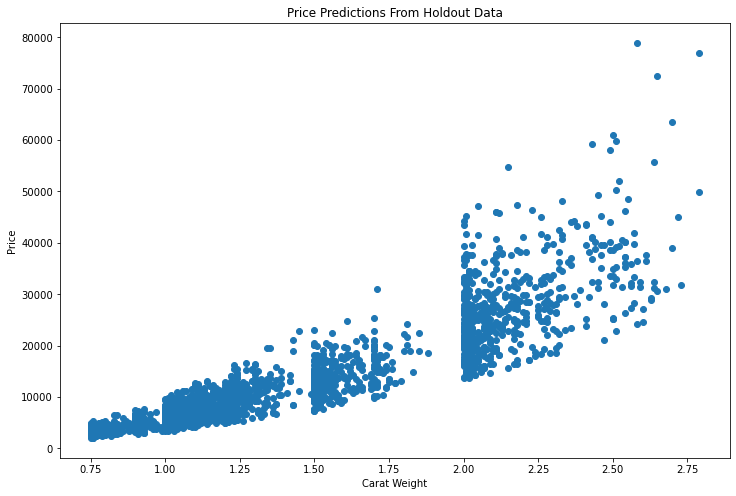

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Price Predictions From Holdout Data')
ax.set_xlabel('Carat Weight')
ax.set_ylabel('Price')
ax.scatter(X_holdout['Carat Weight'], y_prices)

plt.show()

In [16]:
reg_log_log.coef_

array([-1.12982324e+11, -1.12982324e+11, -1.12982324e+11, -1.12982324e+11,
       -1.12982324e+11, -1.41137514e+12, -1.41137514e+12, -1.41137514e+12,
       -1.41137514e+12, -1.41137514e+12, -1.41137514e+12, -4.23615436e+11,
       -4.23615436e+11, -4.23615436e+11, -4.23615436e+11, -4.23615436e+11,
       -4.23615436e+11,  2.67495711e+12,  2.67495711e+12,  2.67495711e+12,
        2.67495711e+12, -1.66825884e+12, -1.66825884e+12, -1.66825884e+12,
       -1.66825884e+12,  6.74203781e+11,  6.74203781e+11,  1.97021321e+00,
        2.00485623e-01])

In [17]:
reg_log_log.intercept_

267070840896.3299

In [25]:
# import libraries
from keras.layers import Dense
from keras.models import Sequential

In [26]:
model = Sequential()
model.add(Dense(29, activation='relu', input_shape=(X_manip.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
4497/4497 [==============================] - 0s 58us/step - loss: 12.2501
Epoch 2/100
4497/4497 [==============================] - 0s 26us/step - loss: 0.1217
Epoch 3/100
4497/4497 [==============================] - 0s 32us/step - loss: 0.0605
Epoch 4/100
4497/4497 [==============================] - 0s 27us/step - loss: 0.0383
Epoch 5/100
4497/4497 [==============================] - 0s 25us/step - loss: 0.0279
Epoch 6/100
4497/4497 [==============================] - 0s 27us/step - loss: 0.0227
Epoch 7/100
4497/4497 [==============================] - 0s 27us/step - loss: 0.0195
Epoch 8/100
4497/4497 [==============================] - 0s 26us/step - loss: 0.0166
Epoch 9/100
4497/4497 [==============================] - 0s 26us/step - loss: 0.0148
Epoch 10/100
4497/4497 [==============================] - 0s 26us/step - loss: 0.0142
Epoch 11/100
4497/4497 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 12/100
4497/4497 [==============================] - 0s 2

In [27]:
# predict X_test data
y_NN_pred = model.predict(X_test)

In [28]:
# find RMSE of using DNN
print('Deep Neural Network RMSE: ' + str(round(mean_squared_error(y_test, y_NN_pred, squared=False), 5)))

Deep Neural Network RMSE: 0.0893


In [29]:
# test DNN with holdout data
# predict diamond prices
y_holdout_NN_pred = model.predict(X_holdout_manip)

# must exp transform to get prices from log output
y_NN_prices = np.exp(y_holdout_NN_pred)

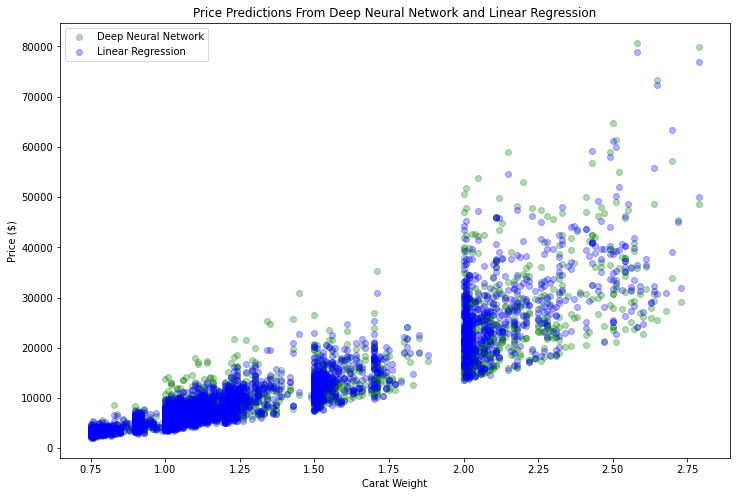

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Price Predictions From Deep Neural Network and Linear Regression')
ax.set_xlabel('Carat Weight')
ax.set_ylabel('Price ($)')
ax.scatter(X_holdout['Carat Weight'], y_NN_prices, color='g', alpha=0.3, label='Deep Neural Network')
ax.scatter(X_holdout['Carat Weight'], y_prices, color='b', alpha=0.3, label='Linear Regression')

plt.legend()
plt.show()

In [31]:
# compare training results of DNN and lin reg
print('Deep Neural Network RMSE: ' + str(round(mean_squared_error(y_test, y_NN_pred, squared=False), 5)))
print('Multiple Linear Regression RMSE: ' + str(round(mean_squared_error(y_test, y_pred, squared=False), 5)))

Deep Neural Network RMSE: 0.0893
Multiple Linear Regression RMSE: 0.09715
